# Yongjie's CA2-Unsupervised Model

Name: Li Yongjie

ID: 2342377

Class: DAAA/FT/1B/01

## Objective
Use unsupervised learning to group the students into multiple clusters so that we can cater needs
for different students

<hr>

### Importing the neccessary libraries

In [153]:
import os
os.environ["OMP_NUM_THREADS"] = "1" # Set this before importing sklearn

# Import necassary libraries
from sklearn.datasets import load_iris
from sklearn.mixture import GaussianMixture
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import KNNImputer
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

# Basic Libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# Sklearn Libraries
import sklearn
from sklearn.cluster import KMeans, AgglomerativeClustering, SpectralClustering, DBSCAN
from scipy.cluster.hierarchy import dendrogram
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Others
from typing import Sequence, Tuple
from itertools import combinations, chain
# from kmodes.kprototypes import KPrototypes

df = pd.read_csv("./Student_Performance_dataset.csv")

print(df.head(5))

   Student_ID  Gender  Age  English_Score  Math_Score  Science_Score
0           1  Female   18           64.0        56.0             60
1           2  Female   12           89.0        71.0             97
2           3  Female   18           69.0        69.0             80
3           4  Female   17           60.0        72.0             97
4           5    Male   13           71.0        76.0             76


In [154]:
sns.set_theme(palette='bright')
# Set the style for plots
plt.style.use('seaborn-v0_8-darkgrid')

<hr>

### Exploratory Data Analysis
<hr>

We will conduct an exploratory data analysis to gain insights into the characteristics of the dataset. Our focus will primarily be on understanding how each feature relates to the target variable, as predicting the target is our main objective. This analysis is crucial for guiding us on how to proceed with feature engineering.

This dataset pertains to student performance and contains 1000 data points with 6 columns:

*   **Student\_ID**: Unique identifier for each student
*   **Gender**: Student's gender
*   **Age**: Student's age
*   **English\_Score**: Student's score in English subject
*   **Math\_Score**: Student's score in Math subject
*   **Science\_Score**: Student's score in Science subject

In [155]:
df.drop(columns='Student_ID', inplace=True)

In [156]:
# Get description 
df.describe()

,Age,English_Score,Math_Score,Science_Score
count,1000.000000,971.000000,967.000000,1000.000000
mean,14.970000,76.089598,76.660807,76.370000
std,1.959832,12.767113,12.541226,12.866649
min,12.000000,55.000000,55.000000,55.000000
25%,13.000000,65.000000,66.000000,65.000000
50%,15.000000,76.000000,76.000000,77.000000
75%,17.000000,88.000000,87.500000,87.000000
max,18.000000,98.000000,98.000000,98.000000


In [157]:
df.dtypes

Gender            object
Age                int64
English_Score    float64
Math_Score       float64
Science_Score      int64
dtype: object

In [158]:
df['Gender'].unique()

array(['Female', 'Male', 'Genderqueer', 'Non-binary', 'Agender',
       'Bigender', 'Genderfluid', 'Polygender'], dtype=object)

In [159]:
# df = df.drop(df[['Student_ID', 'Gender']],axis=1)

In [160]:
df.isnull().sum()

Gender            0
Age               0
English_Score    29
Math_Score       33
Science_Score     0
dtype: int64

In [161]:
# enc = OneHotEncoder(drop="first")
# enc.fit(df[['Gender']])
# df_encoded = pd.DataFrame(enc.transform(df[['Gender']]).toarray(), columns=enc.get_feature_names_out(['Gender']))
# df = pd.concat([df, df_encoded], axis=1)

# df = df.drop(df[['Gender']], axis = 1)
# df

In [162]:
df_eda = df.copy()

<hr>

### Univariate Analyisis
<hr>

We will now do univariate analysis to find out more about each feature

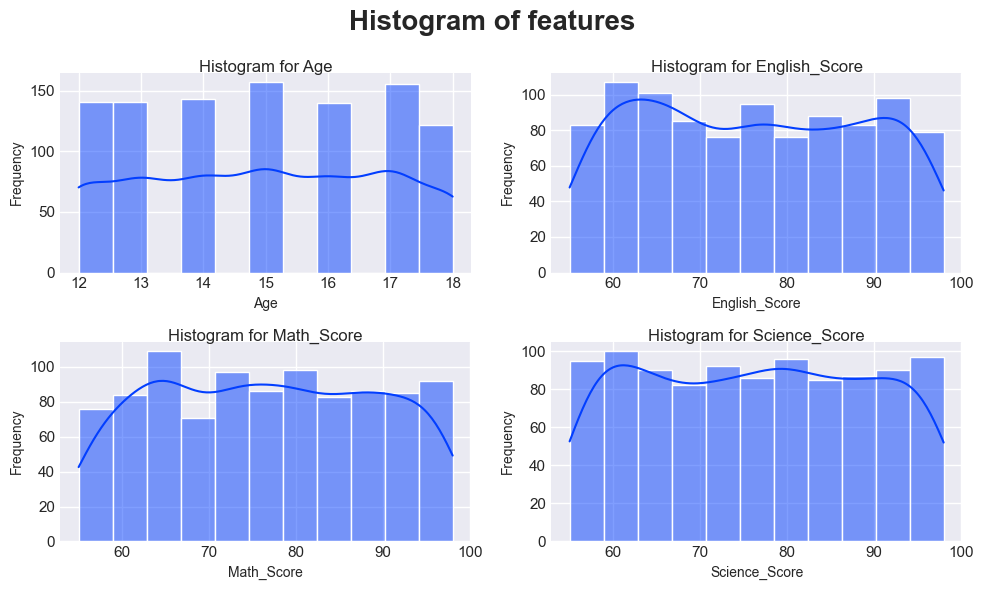

In [163]:
fig, axs = plt.subplots(2, 2 , tight_layout=False, figsize=(10, 6))

for i, (col, ax) in enumerate(zip(df_eda.columns[1:], axs.flatten())):
    sns.histplot(df[col], ax=ax, kde=True)
    ax.set_xlabel(col, fontsize=10)
    ax.set_ylabel("Frequency", fontsize=10)
    ax.set_title(f"Histogram for {col}", fontsize=12, pad=0.4)
    
plt.suptitle("Histogram of features", fontsize=20, fontweight='bold')
plt.show()

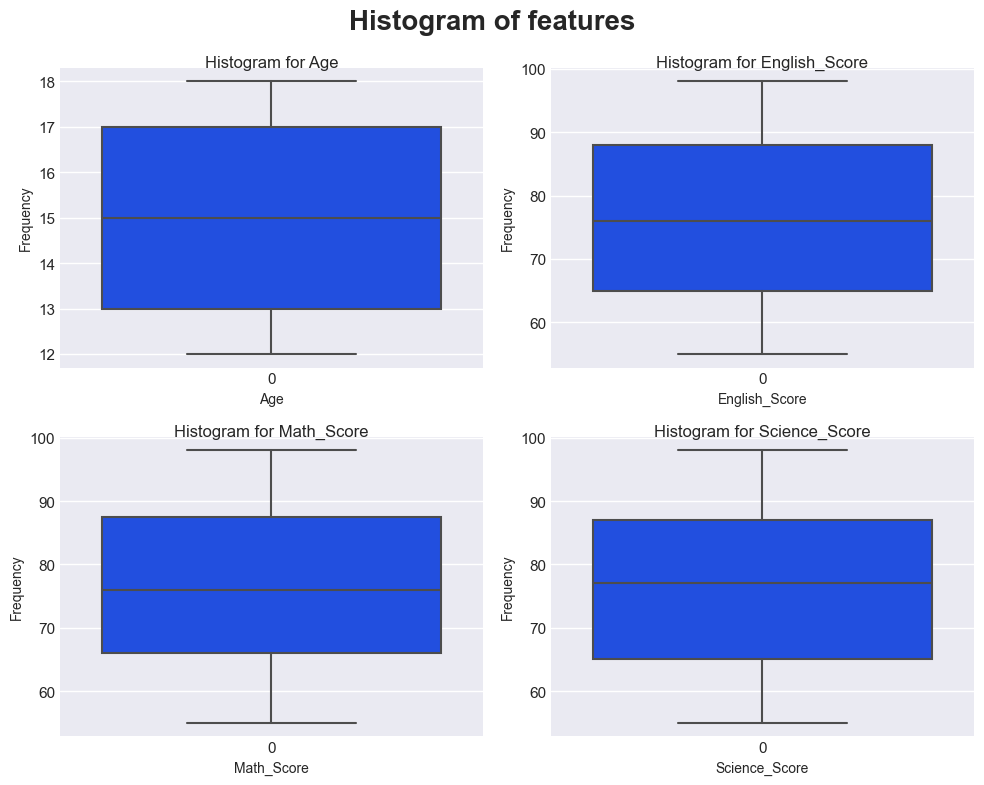

In [164]:
fig, axs = plt.subplots(2, 2 , tight_layout=False, figsize=(10, 8))

for i, (col, ax) in enumerate(zip(df_eda.columns[1:], axs.flatten())):
    sns.boxplot(df[col], ax=ax)
    ax.set_xlabel(col, fontsize=10)
    ax.set_ylabel("Frequency", fontsize=10)
    ax.set_title(f"Histogram for {col}", fontsize=12, pad=0.4)
    
plt.suptitle("Histogram of features", fontsize=20, fontweight='bold')
plt.show()

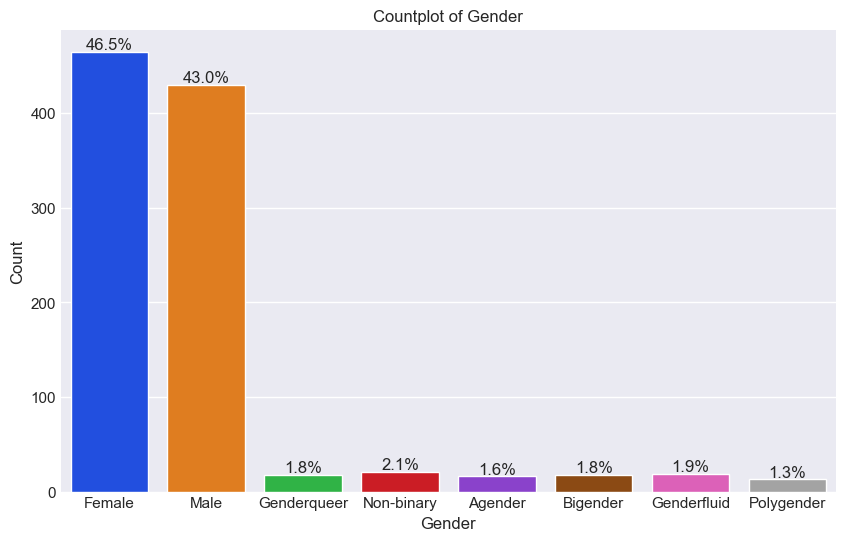

In [165]:
# Calculate the percentage of each gender
percentages = df['Gender'].value_counts(normalize=True) * 100

# Plot the countplot
plt.figure(figsize=(10, 6))
ax = sns.countplot(data=df, x='Gender')

# Add percentages as text labels on top of each bar
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height/len(df)*100:.1f}%', (p.get_x() + p.get_width() / 2., height),
                ha='center', va='center', xytext=(0, 5), textcoords='offset points')

ax.set(xlabel='Gender', ylabel='Count')
plt.title('Countplot of Gender')
plt.show()

In [166]:
def groupNonBinaryGender(name):
    if name != 'Female' and name!= "Male":
        return "Others"
    else:
        return name
    
df_eda['Gender'] = df_eda['Gender'].apply(groupNonBinaryGender)

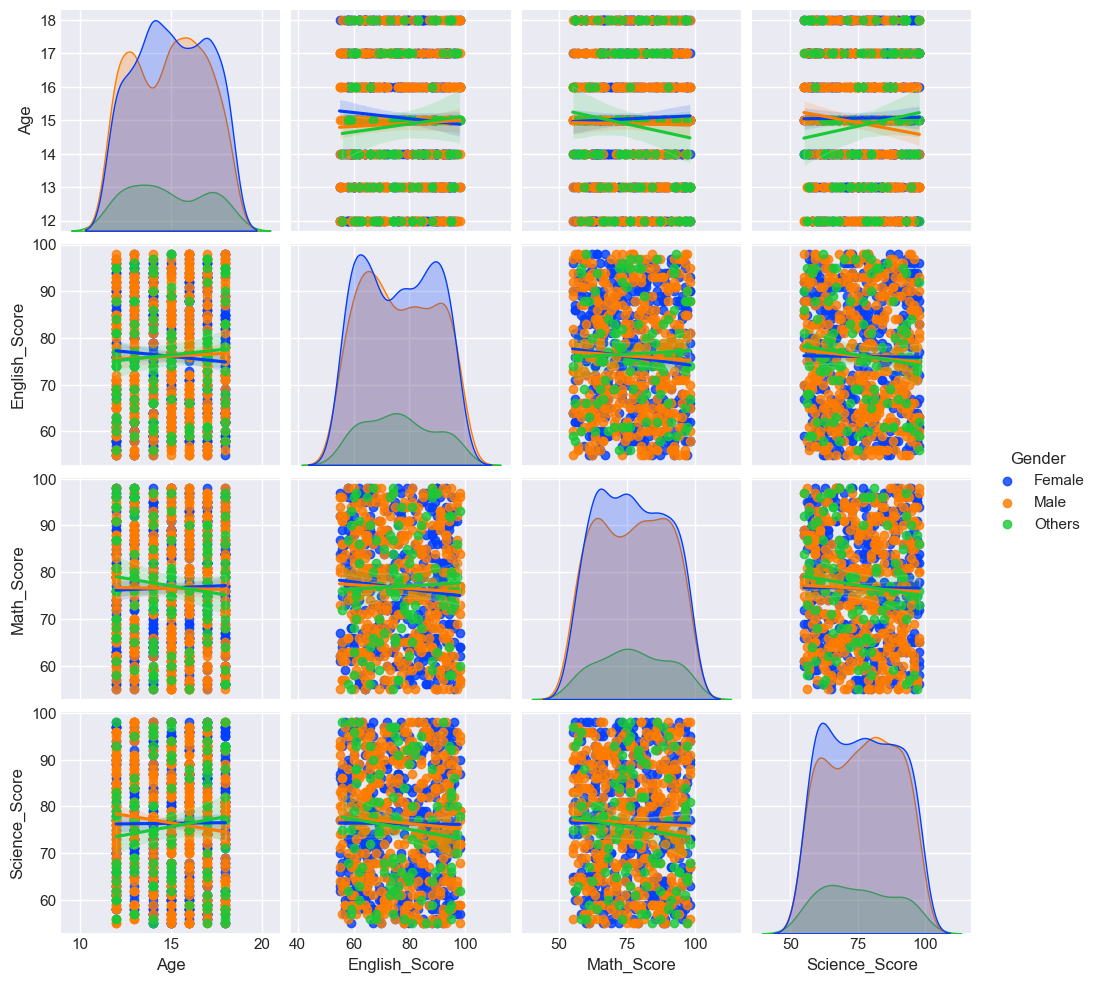

In [167]:
sns.pairplot(df_eda, kind='reg', hue='Gender')
plt.show()

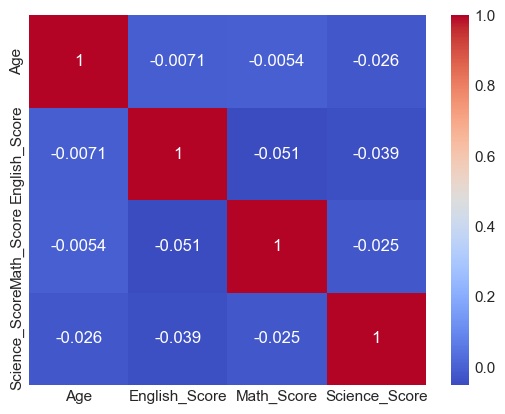

In [168]:
sns.heatmap(df_eda.drop(columns='Gender').corr(), annot=True, cmap='coolwarm')
plt.show()

### Imputing missing data

In [169]:
cols = ['English_Score', 'Math_Score']
imputer = KNNImputer()
df_eda.loc[:,cols] = imputer.fit_transform(df_eda[cols])

### Getting average score

In [170]:
df_eda['Average score'] = df[['English_Score', 'Math_Score', 'Science_Score']].mean(axis=1)
df_eda

,Gender,Age,English_Score,Math_Score,Science_Score,Average score
0,Female,18,64.0,56.0,60,60.000000
1,Female,12,89.0,71.0,97,85.666667
2,Female,18,69.0,69.0,80,72.666667
3,Female,17,60.0,72.0,97,76.333333
4,Male,13,71.0,76.0,76,74.333333
...,...,...,...,...,...,...
995,Female,14,64.0,55.0,77,65.333333
996,Others,14,66.0,60.0,56,60.666667
997,Male,16,82.0,81.0,74,79.000000
998,Male,14,76.0,62.0,62,66.666667


### Scaling the data

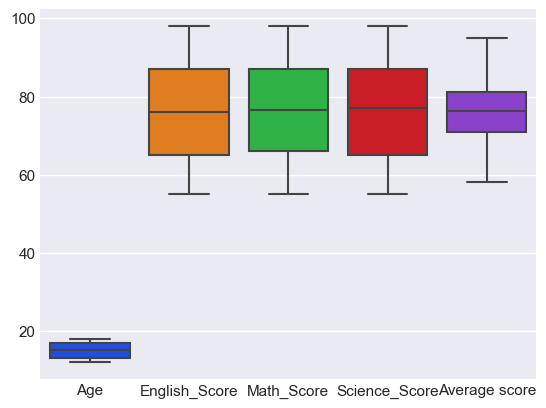

In [171]:
sns.boxplot(df_eda)
plt.show()

In [172]:
scale = StandardScaler()
col=list(df_eda.drop(columns='Gender').columns)
df_scaled = df_eda.copy()
df_scaled[col] = scale.fit_transform(df_scaled[col])

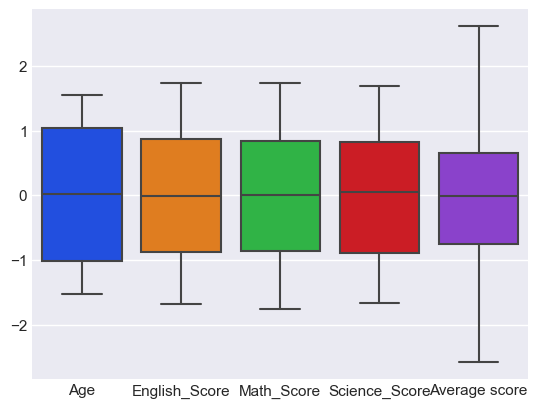

In [173]:
sns.boxplot(df_scaled)
plt.show()

In [174]:
# One Hot Encoding
df_scaled = pd.get_dummies(df_scaled, drop_first=True)

# Verifying the change
df_scaled.head()

,Age,English_Score,Math_Score,Science_Score,Average score,Gender_Male,Gender_Others
0,1.546825,-0.960065,-1.666859,-1.272918,-2.292898,False,False
1,-1.516194,1.023610,-0.454347,1.604172,1.301498,False,False
2,1.546825,-0.563330,-0.616015,0.282266,-0.519040,False,False
3,1.036321,-1.277454,-0.373512,1.604172,-0.005555,False,False
4,-1.005691,-0.404636,-0.050176,-0.028771,-0.285638,True,False


### K-means Clustering

In [189]:
df_scaled.rename(columns={"English_Score": "Eng", "Math_Score": "Math", "Science_Score":"Sci", "Average score": "Avg", "Gender_Male":"Male", "Gender_Others":"Others"}, inplace=True)

In [175]:
df_kmeans = df_scaled.copy()

c:\Users\yongj\anaconda3\envs\AIML\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\yongj\anaconda3\envs\AIML\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\yongj\anaconda3\envs\AIML\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\yongj\anaconda3\envs\AIML\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change fr

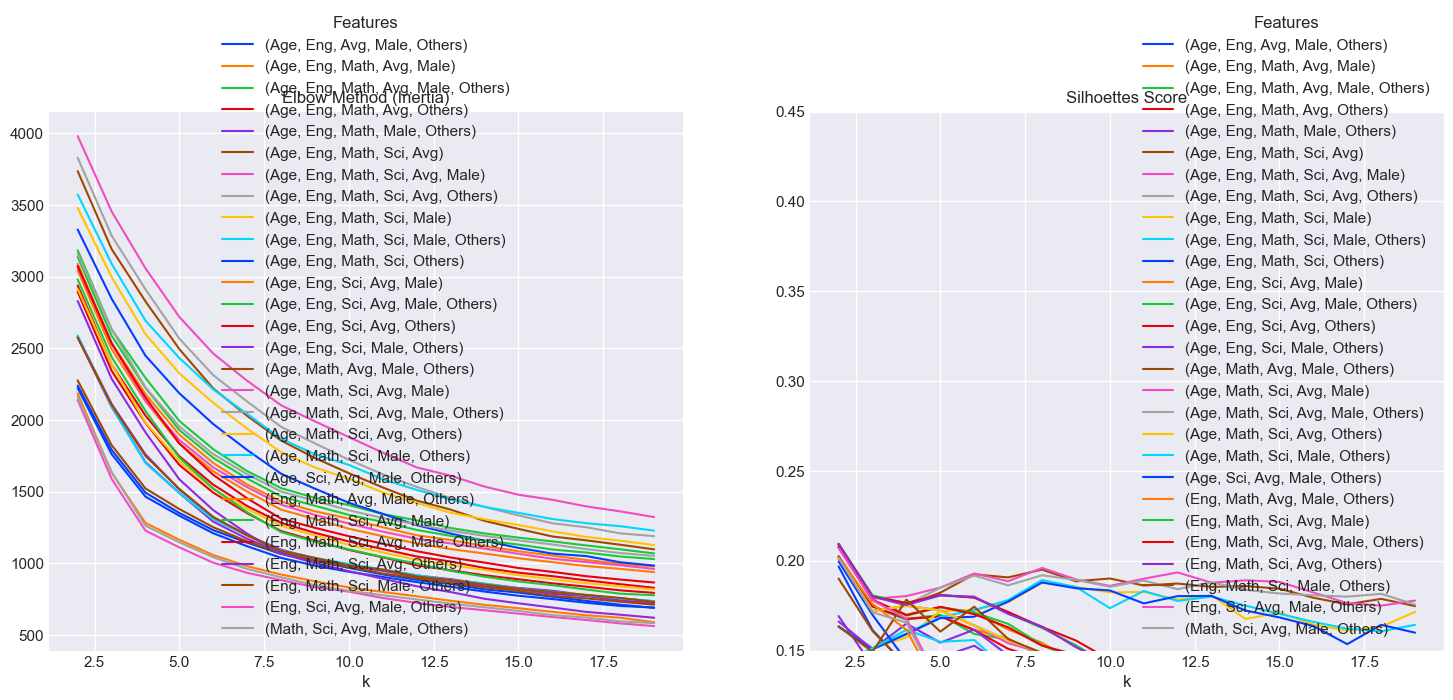

In [191]:
#  Calculate inertia and silhouette score for each k value
def calculate_k_mean(n_cluster: int, X: Sequence)-> Tuple[float, Sequence, Sequence, sklearn.cluster._kmeans.KMeans]:
    kmean = KMeans(n_clusters = n_cluster, random_state=24)
    cluster_labels = kmean.fit_predict(X)
    return kmean.inertia_, cluster_labels, kmean.cluster_centers_, kmean

# Calculate inertia and silhouette score for each set of features and k value
features_sets = chain(combinations(df_scaled.columns,5), combinations(df_scaled.columns,6)) # Different Subset of attributes
logs = []
k_range = range(2,20) # Range of k values
for features in features_sets:
    for k in k_range:
        inertia, cluster_labels, _, _ = calculate_k_mean(k, df_scaled[list(features)])
        silhoettes_avg = silhouette_score(df_scaled, cluster_labels)
        logs.append([features, k, inertia, silhoettes_avg])
        
records_df = pd.DataFrame(logs, columns=['Features', 'k', 'Inertia', 'Silhoettes_Avg']).set_index("Features") # Saving history to dataframe
silhoettes_pivot = records_df.pivot_table(values = 'Silhoettes_Avg', index='k', columns='Features') 
inertia_pivot = records_df.pivot_table(values = 'Inertia', index='k', columns='Features')

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (18, 7))

inertia_pivot.plot(ax = ax1)
ax1.set_title("Elbow Method (Inertia)")

silhoettes_pivot.plot(ax=ax2)
ax2.set_title("Silhoettes Score")
ax2.set_ylim(0.15, 0.45) # Set y lim to make legend more visible

plt.show()

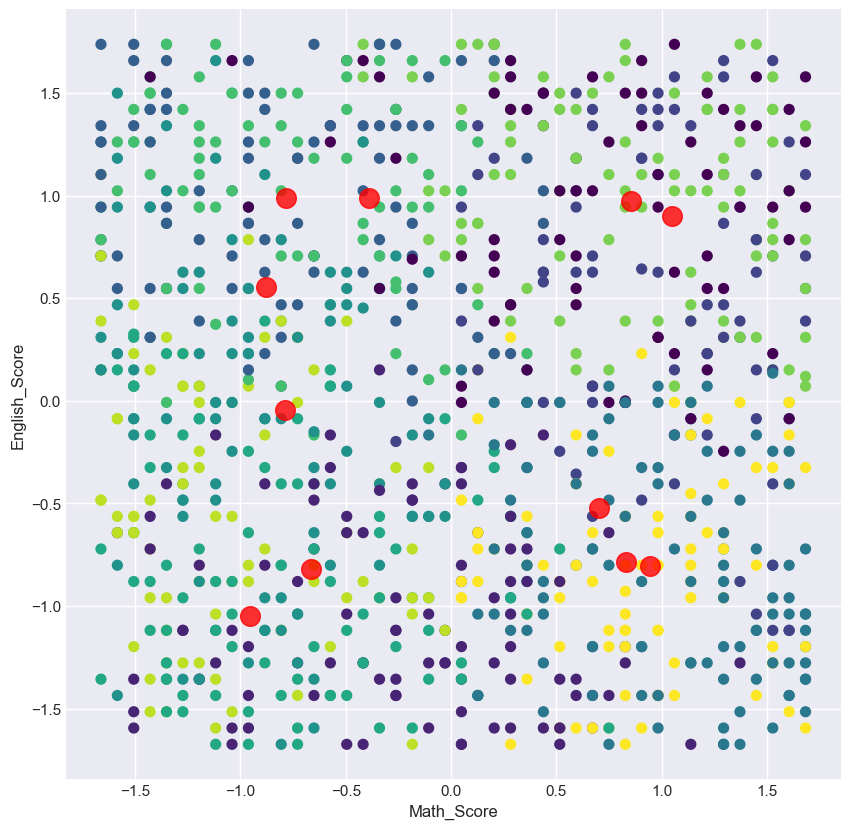

In [ ]:
# K-means Clustering
from sklearn.datasets import load_iris
from sklearn.cluster import KMeans
import pandas as pd

# fit a Kmeans model to the data
model = KMeans(n_clusters=11, n_init=10)
model.fit(df_kmeans)
# Visualize the results
import matplotlib.pyplot as plt
y_kmeans = model.predict(df_kmeans)
# scatter plot the sepal length versus sepal width
plt.figure(figsize=(10,10))
plt.scatter(df_kmeans['Science_Score'], df_kmeans['English_Score'], c=y_kmeans, s=50, cmap='viridis')
# plot centroids for each cluster
centers = model.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='red', s=200, alpha=0.8)
plt.xlabel('Math_Score')
plt.ylabel('English_Score')
plt.show()


In [ ]:
cluster_labels = model.labels_
df_kmeans = df_eda.copy()
df_kmeans['Cluster_KMeans'] = cluster_labels
kmeans_stats = df_kmeans.groupby('Cluster_KMeans').mean().sort_values(by='Average score', ascending=False)
kmeans_stats

,Age,English_Score,Math_Score,Science_Score,Average score,Gender_Male,Gender_Others
Cluster_KMeans,,,,,,,
2,13.253333,83.117333,89.266667,89.240000,87.360000,0.613333,0.053333
0,17.025000,87.461120,85.525760,84.875000,86.385417,0.387500,0.125000
8,14.210000,88.546000,65.108000,87.220000,80.428333,0.360000,0.100000
7,13.435294,88.588235,86.056471,66.482353,80.337255,0.317647,0.141176
4,16.600000,66.210435,80.441739,89.173913,78.684058,0.356522,0.121739
3,16.640449,88.349321,69.740009,66.808989,74.887640,0.483146,0.078652
1,13.102041,62.877551,86.100000,73.612245,74.056122,0.397959,0.142857
9,16.346154,69.525641,89.743590,62.730769,74.000000,0.487179,0.089744
10,13.666667,65.759524,64.142857,87.630952,72.650794,0.571429,0.083333


<hr>

### Finding K

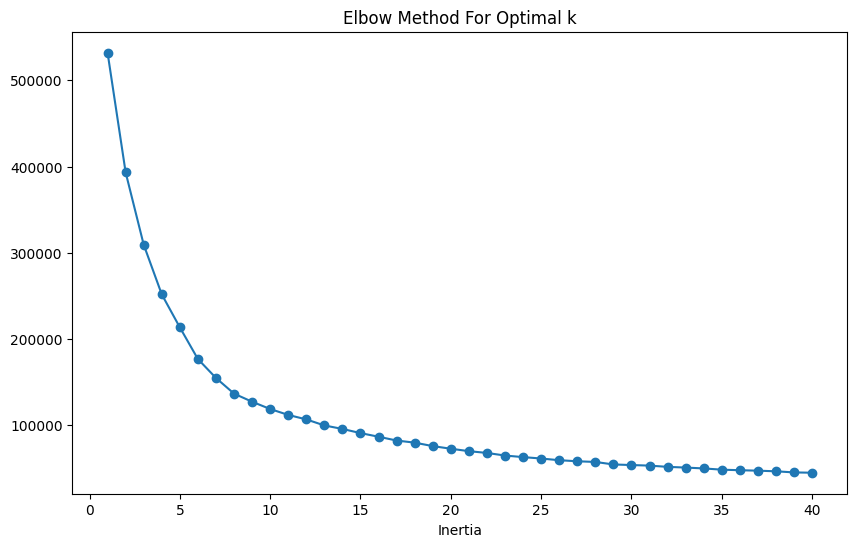

In [ ]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Calculate the within-cluster sum of squares (inertia) for different number of clusters
inertia = []
for i in range(1, 41):
    kmeans = KMeans(n_clusters=i, n_init=10, random_state=10).fit(df_eda)
    inertia.append(kmeans.inertia_)

# Plot the elbow method graph
plt.figure(figsize=(10,6))
plt.plot(range(1,41), inertia, marker='o', linestyle='-')
plt.title("Elbow Method For Optimal k")
plt.xlabel("Inertia")

plt.show()

In [ ]:
# gap statistics

<hr>

### Hierichal Clustering

In [ ]:
df_hierichal = df_scaled.copy()

In [ ]:
# importing libraries
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np 

scores = []
for i, k in enumerate(np.arange(3,16)):
    # Perform k-means clustering
    kmeans = KMeans(n_clusters=k, n_init=10, random_state=0).fit(df_hierichal)
    cluster_labels = kmeans.labels_

    # Calculate the silhouette score
    silhouette_avg = silhouette_score(df_hierichal, cluster_labels)
    print(f"For n_clusters = {k}, the average silhoutte_score is : {silhouette_avg}")

    # Compute the silhoutte scores for each sample
    sample_silhoutte_values = silhouette_samples(df_hierichal, cluster_labels)
    scores.append(silhouette_avg)
print(f"\nThe highest avg silhoutte_score is: {max(scores)}, n_cluster={scores.index(max(scores))+3}")

For n_clusters = 3, the average silhoutte_score is : 0.19749676555730225
For n_clusters = 4, the average silhoutte_score is : 0.1972357170765534
For n_clusters = 5, the average silhoutte_score is : 0.20634142973189087
For n_clusters = 6, the average silhoutte_score is : 0.21520663352139008
For n_clusters = 7, the average silhoutte_score is : 0.2141658999740446
For n_clusters = 8, the average silhoutte_score is : 0.2218699591879444
For n_clusters = 9, the average silhoutte_score is : 0.21507705113228445
For n_clusters = 10, the average silhoutte_score is : 0.21805651817027932
For n_clusters = 11, the average silhoutte_score is : 0.22248887685516486
For n_clusters = 12, the average silhoutte_score is : 0.2188556909946335
For n_clusters = 13, the average silhoutte_score is : 0.21937431114055536
For n_clusters = 14, the average silhoutte_score is : 0.22078669965154388
For n_clusters = 15, the average silhoutte_score is : 0.21758596010350476

The highest avg silhoutte_score is: 0.2224888768

In [ ]:
from scipy.spatial.distance import pdist, squareform

# sampling a subset of the data
sampled_df = df_hierichal.sample(n=1000) #we are not doing any sampling since there are only 50 rows. Lower

# calculate the dissimilarity matrix
d_sampled = pdist(sampled_df, metric='euclidean')

# convert to squareform
square_d_sampled = squareform(d_sampled)

# convert to pandas dataframe (if you wish to view the data)
distance_df_sampled = pd.DataFrame(square_d_sampled, index=sampled_df.index, columns=sampled_df.index)

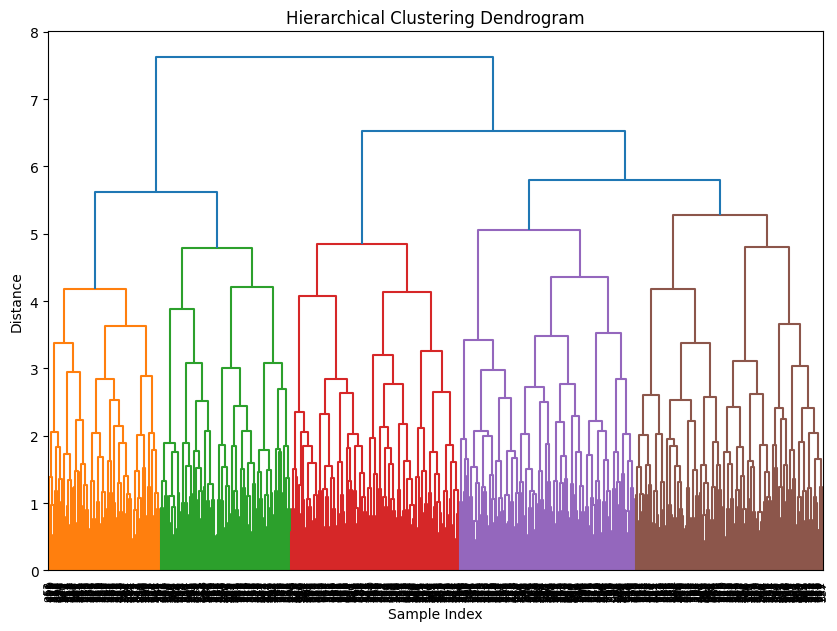

In [ ]:
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
import matplotlib.pyplot as plt

plt.figure(figsize=(10,7))
hc = linkage(df_hierichal, method='complete')  # Perform hierarchical clustering using the condensed distance matrix
dendrogram(hc, labels=df_hierichal.index, leaf_rotation=90, leaf_font_size=8)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Sample Index')
plt.ylabel('Distance')
plt.show()

# Choose the number of clusters based on dendrogram visualization or a threshold
num_clusters_hc = 11

# Cut the dendrogram to obtain clusters
cluster_labels_hc = fcluster(hc, num_clusters_hc, criterion='maxclust')

# Assign cluster labels to the DataFrame
df_hierichal = df_eda.copy()
df_hierichal['Cluster_HC'] = cluster_labels_hc

In [ ]:
cluster_stats = df_hierichal.groupby('Cluster_HC').mean().sort_values(by='Average score', ascending=False)
cluster_stats

,Age,English_Score,Math_Score,Science_Score,Average score
Cluster_HC,,,,,
2,13.458333,85.870689,81.806400,92.027778,86.807870
3,16.770833,80.906250,87.322917,88.145833,85.657986
1,14.572414,88.991724,85.332414,66.496552,80.231034
11,13.149254,64.038806,91.328358,80.791045,78.810945
7,13.905882,85.000000,63.221176,84.964706,77.882353
8,17.092308,84.883077,67.907692,79.876923,77.610256
6,16.428571,65.148052,71.218182,91.272727,75.980519
10,16.333333,66.666667,90.079365,67.317460,74.687831
9,12.991071,65.452586,75.405900,74.375000,71.648810


<hr>

### GMM Clustering

In [ ]:
df_gmm = df_scaled.copy()

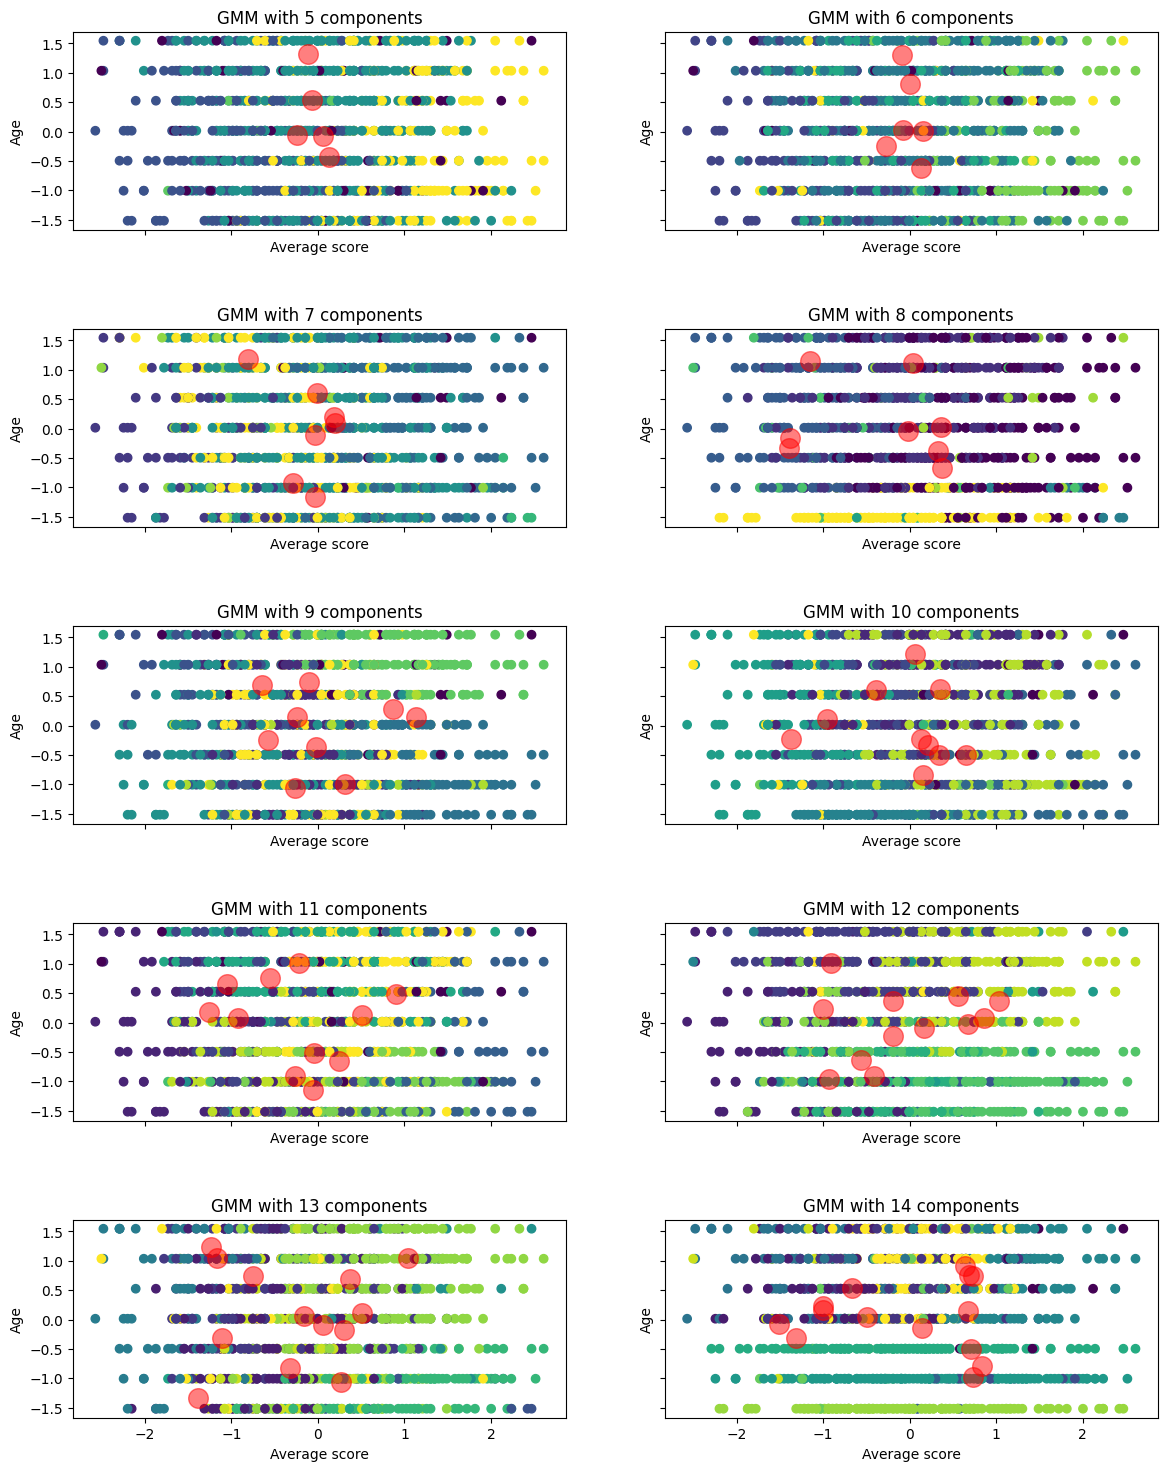

In [ ]:
fig, axes = plt.subplots(5,2, figsize=(14,18), sharex=True, sharey=True, gridspec_kw={'hspace': 0.5}) #1 row, 3 columns

axes = axes.flatten()
# Loop over each n_components (2 to 4)
for i, n in enumerate(range(5,15)):
    # Create GMM
    gmm = GaussianMixture(n_components=n, random_state=0)
    gmm.fit(df_gmm)
    labels = gmm.predict(df_gmm)

    # Plotting
    axes[i].scatter(df_gmm['Average score'], df_gmm['Age'], c=labels)

    # Plot the 'centers (means of the Gaussian distributions)
    axes[i].scatter(gmm.means_[:, 0], gmm.means_[:, 1], c='red', s=200, alpha=0.5) #gmm.means_ are
    axes[i].set_title(f'GMM with {n} components')
    axes[i].set_xlabel('Average score')
    axes[i].set_ylabel('Age')

plt.show()

In [ ]:
gmm = GaussianMixture(n_components=11, random_state=0)
gmm.fit(df_gmm)
labels = gmm.predict(df_gmm)

# 2. Get the assigned probabilities
probabilities = gmm.predict_proba(df_gmm)

# 3. Create a dataframe of probabilities
prob_df = pd.DataFrame(probabilities, columns=[f'Prob_Cluster_{i}' for i in range(1,12)])

# 4. Concat it to the original dataframe
result_df = pd.concat([df_gmm, prob_df], axis=1)

result_df

,Age,English_Score,Math_Score,Science_Score,Average score,Prob_Cluster_1,Prob_Cluster_2,Prob_Cluster_3,Prob_Cluster_4,Prob_Cluster_5,Prob_Cluster_6,Prob_Cluster_7,Prob_Cluster_8,Prob_Cluster_9,Prob_Cluster_10,Prob_Cluster_11
0,1.546825,-0.960065,-1.666859,-1.272918,-2.292898,8.147924e-11,5.090752e-01,1.043953e-02,4.536290e-30,0.0,2.153481e-230,4.803855e-01,1.253525e-50,9.167876e-16,9.919796e-05,5.070013e-07
1,-1.516194,1.023610,-0.454347,1.604172,1.301498,1.583894e-20,6.402155e-05,2.041947e-18,9.821480e-01,0.0,0.000000e+00,7.642476e-08,3.811094e-12,7.804597e-03,8.177378e-03,1.805940e-03
2,1.546825,-0.563330,-0.616015,0.282266,-0.519040,1.900502e-04,6.709880e-02,1.119286e-02,7.583069e-09,0.0,2.896084e-35,5.886268e-01,1.254608e-43,2.552928e-13,1.304503e-03,3.315870e-01
3,1.036321,-1.277454,-0.373512,1.604172,-0.005555,3.707585e-04,1.921579e-03,2.116137e-03,6.980229e-07,0.0,0.000000e+00,1.352480e-03,2.981279e-29,4.698124e-13,3.527952e-07,9.942380e-01
4,-1.005691,-0.404636,-0.050176,-0.028771,-0.285638,5.234375e-05,1.774176e-02,8.767626e-03,9.844615e-09,0.0,6.440277e-04,8.848663e-04,1.644966e-02,5.956691e-01,3.207479e-02,3.277158e-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,-0.495188,-0.960065,-1.747694,0.048988,-1.546010,4.384693e-05,9.751668e-01,8.656523e-05,2.866840e-12,0.0,2.513126e-06,2.505749e-04,5.432908e-11,3.031008e-06,3.866157e-04,2.406008e-02
996,-0.495188,-0.801371,-1.343523,-1.583955,-2.199537,2.959195e-06,9.036194e-01,7.954268e-04,2.263794e-32,0.0,0.000000e+00,7.199146e-03,9.715314e-09,3.906106e-04,8.799200e-02,4.285250e-07
997,0.525818,0.468181,0.353995,-0.184289,0.367889,7.130904e-04,7.731898e-08,1.561023e-06,1.157724e-07,0.0,1.072506e-05,9.634680e-01,2.658739e-16,3.949622e-04,1.522480e-03,3.388902e-02
998,-0.495188,-0.007901,-1.181854,-1.117400,-1.359288,6.415292e-05,4.570598e-02,5.010225e-07,1.494477e-20,0.0,2.683824e-167,1.195606e-02,1.206346e-09,2.554772e-03,9.396842e-01,3.435840e-05


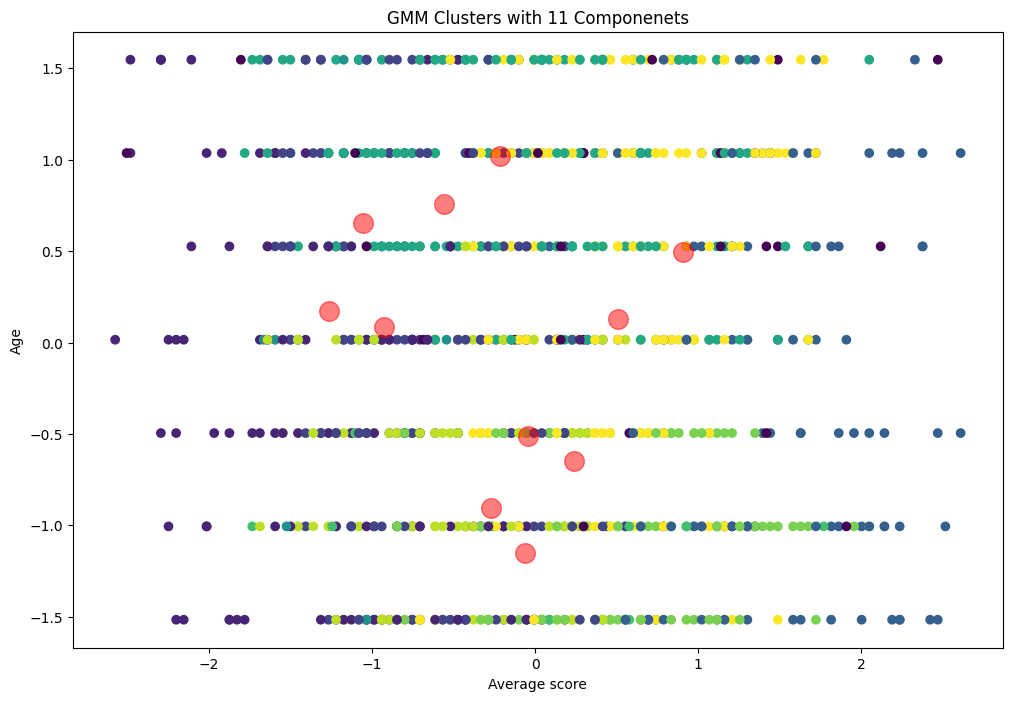

In [ ]:
plt.figure(figsize=(12,8))
plt.scatter(df_gmm['Average score'], df_gmm['Age'], c=labels)
plt.scatter(gmm.means_[:, 0], gmm.means_[:, 1], c='red', s=200, alpha=0.5)
plt.title('GMM Clusters with 11 Componenets')
plt.xlabel('Average score')
plt.ylabel('Age')
plt.show()

In [ ]:
assigned_clusters = np.argmax(probabilities, axis=1)
df_gmm = df_eda.copy()
df_gmm['Cluster GMM'] = assigned_clusters

In [ ]:
df_gmm.groupby('Cluster GMM').mean().sort_values(by='Average score',ascending=False )

,Age,English_Score,Math_Score,Science_Score,Average score
Cluster GMM,,,,,
3,14.533333,89.161905,77.085714,92.838095,86.361905
8,12.877358,84.584906,85.537736,69.141509,79.754717
10,15.607955,67.784091,81.528409,89.500000,79.604167
0,16.000000,77.820897,73.547297,79.393939,78.484848
4,12.500000,78.300000,63.500000,93.000000,78.250000
7,13.153846,77.076923,80.815385,71.923077,76.192308
6,16.750000,83.923469,77.175510,67.102041,76.067177
9,13.766990,86.029126,63.757282,70.233010,73.339806
2,14.918519,61.333333,86.014815,68.948148,72.098765


### PDA

In [ ]:
df_pda = df_scaled.copy()
df_pda


,Age,English_Score,Math_Score,Science_Score,Average score
0,1.546825,-0.960065,-1.666859,-1.272918,-2.292898
1,-1.516194,1.023610,-0.454347,1.604172,1.301498
2,1.546825,-0.563330,-0.616015,0.282266,-0.519040
3,1.036321,-1.277454,-0.373512,1.604172,-0.005555
4,-1.005691,-0.404636,-0.050176,-0.028771,-0.285638
...,...,...,...,...,...
995,-0.495188,-0.960065,-1.747694,0.048988,-1.546010
996,-0.495188,-0.801371,-1.343523,-1.583955,-2.199537
997,0.525818,0.468181,0.353995,-0.184289,0.367889
998,-0.495188,-0.007901,-1.181854,-1.117400,-1.359288


In [ ]:
pca = PCA(n_components = 2)
pca_result = pca.fit_transform(df_scaled)
# Create a DataFrame with the PCA results
pca_df = pd.DataFrame(data=pca_result, columns=[f"PC{i+1}" for i in range(2)])

# Display the PCA results
print("\nPCA Results:")
pca_df


PCA Results:


,PC1,PC2
0,-3.262638,0.548585
1,1.892945,0.399332
2,-0.764671,-0.106467
3,0.001240,-1.270168
4,-0.358980,-0.399339
...,...,...
995,-2.123069,-0.030593
996,-3.069427,0.420519
997,0.486626,0.327495
998,-1.896016,0.848937


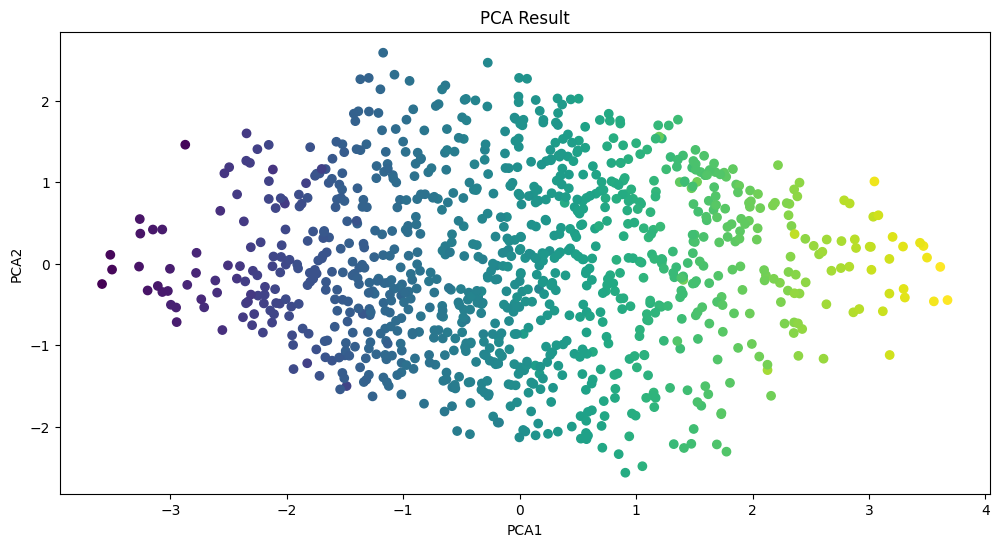

In [ ]:

fig, ax = plt.subplots(1, 1, figsize=(12, 6))

# PCA Plot
ax.scatter(pca_df['PC1'], pca_df['PC2'], c=df_scaled['Average score'], cmap='viridis')
ax.set_title('PCA Result')
ax.set_xlabel('PCA1')
ax.set_ylabel('PCA2')

plt.show()

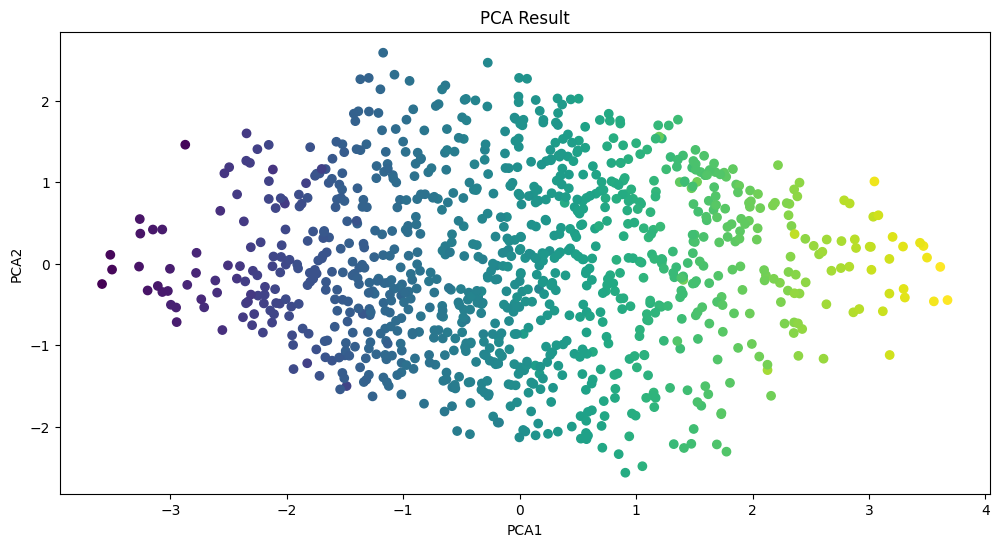

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6))

# PCA Plot
ax.scatter(pca_df['PC1'], pca_df['PC2'], c=df_scaled['Average score'], cmap='viridis')
ax.set_title('PCA Result')
ax.set_xlabel('PCA1')
ax.set_ylabel('PCA2')

plt.show()

In [ ]:
# lda_df = df_scaled.copy()
# lda = LDA(n_components=2)
# lda_y = lda_df['Age']  # Labels
# lda_X = lda_df.drop('Age', axis=1)  # Features
# X_lda = lda.fit_transform(lda_X, lda_y)

In [ ]:
# identify the anomalous point
# argsort returns an array of indexes which will sort the array in ascending order
# so we reverse it via [::-1] and take the top five with [:5]
distances = kmeans.transform(df_scaled)
sorted_idx = np.argsort(distances.ravel())[::-1][:5]

print(sorted_idx[:5])                    ## view the first 10 results of numpy array
print(distances.ravel()[sorted_idx[:5]]) ## Print the distances of the top 5 furthest points

[ 2917  5752     7 11362  8662]
[6.50557574 6.31002058 6.27309858 6.27118728 6.24814961]


c:\Users\yongj\anaconda3\envs\AIML\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


KeyError: "None of [Index([2917, 5752, 7, 11362, 8662], dtype='int64')] are in the [columns]"

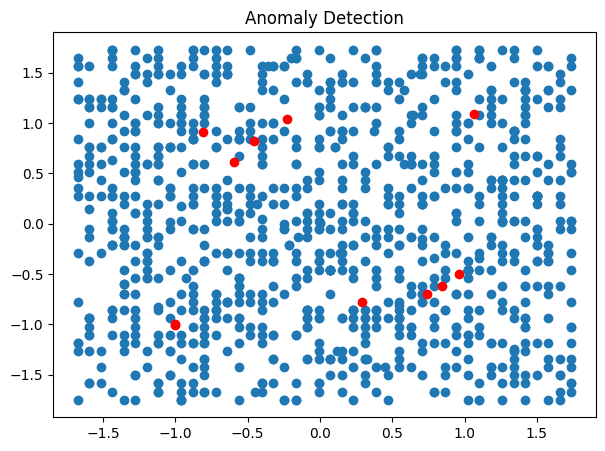

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Assuming df_scaled is your DataFrame
# Perform KMeans clustering (you may need to specify the number of clusters)
kmeans = KMeans(n_clusters=11, random_state=42)
kmeans.fit(df_scaled)

# Scatter plot
fig, ax = plt.subplots(figsize=(7, 5))
ax.set_title("Anomaly Detection")
ax.scatter(df_scaled['English_Score'], df_scaled['Math_Score'], label='Points')
centers = kmeans.cluster_centers_
ax.scatter(centers[:, 0], centers[:, 1], label='Centroid', color='r')
ax.scatter(df_scaled[sorted_idx], df_scaled[sorted_idx],
           label='Anomalies', color='y', s=100)
ax.legend(loc='best')

# Additional plot settings and legend
ax.set_xlabel('English_Score')
ax.set_ylabel('Math_Score')
ax.legend()

# Show the plot
plt.show()